<a href="https://colab.research.google.com/github/Linsonng/text2hologram/blob/main/text2hologram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the Text2Hologram Pipeline

## Overview

The Text2Hologram pipeline is an open-source tool designed to convert text prompts into computer-generated holograms. It incorporates advanced models in generative imaging, super-resolution, depth estimation, and computer-generated holography to create depth-rich holographic images.

This tool aims to serve a diverse audience, from casual users interested in generating holograms from text, to researchers who want to explore the depths of holographic imaging.

### Who is this for?

- **General Public**: If you're interested in quickly generating a hologram from a text description, the [**Simple Mode**](#simple-mode) is for you.
  
- **Advanced Users**: If you have specific requirements, like customizing the number of inference steps or the output directory, the [**Custom Mode**](#custom-mode) offers more control.

- **Researchers**: If you wish to fine-tune every parameter and understand the underlying technology, the [**Researcher Mode**](#researcher-mode) provides full access to all settings.

## Modes

Below, you will find three different modes. Please choose the one that best suits your needs:

1. [**Simple Mode**](#simple-mode): For quick and easy hologram generation. Just provide a text prompt.
    - Go to the Simple Mode section and follow the instructions.
  
2. [**Custom Mode**](#custom-mode): For more control over the hologram generation process without diving deep into the technical details.
    - Go to the Custom Mode section and follow the instructions.

3. [**Researcher Mode**](#researcher-mode): For complete control over every single parameter, intended for research and in-depth exploration.
    - Go to the Researcher Mode section and follow the instructions.

Feel free to read the rest of the paper for an in-depth understanding of the pipeline and its modules.


<a name="simple-mode"></a>
## Simple Mode

### Introduction

Welcome to the Simple Mode of the Text2Hologram pipeline! This mode is designed for users who are new to holography or simply want a quick and hassle-free way to generate a hologram from a text description.

In this mode, you only need to provide a text prompt, and the system will take care of all the other settings using optimized defaults. The Simple Mode offers a one-step solution to hologram generation without the need to worry about technical details.

### How to Use

1. **Provide a Text Prompt**: Input a text description of the scene you want to convert into a hologram.
2. **Run the Cell**: Execute the cell to start the hologram generation process.
3. **View Results**: After the process is complete, the generated hologram and any additional output will be displayed.

### What to Expect

- **Quick Results**: This mode is optimized for speed, offering a streamlined experience.
- **No Technical Jargon**: You won't need to worry about technical settings or parameters.
- **Quality Output**: While the settings are automated, the quality of the generated hologram is assured.




Setup complete! You're now ready to create and display images.
Creating images.


  0%|          | 0/40 [00:00<?, ?it/s]

Image saved as CGH_output//A guitarist playing .jpg
Super-resolution is applied to create 4K images, requiring more memory. If crashing, use --super_reso=false to disable.
single-image-super-resolution-1032 already downloaded to model
Depth acquired.


Gradient Descent, loss:15551.3457
Outputs stored at CGH_output/


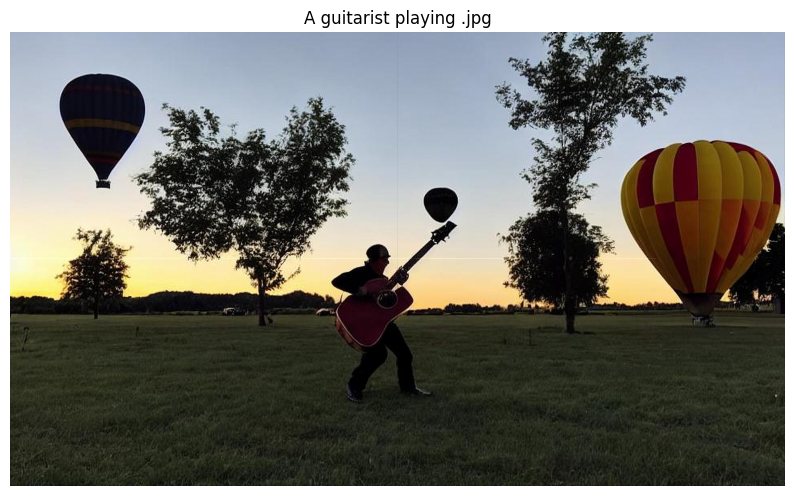

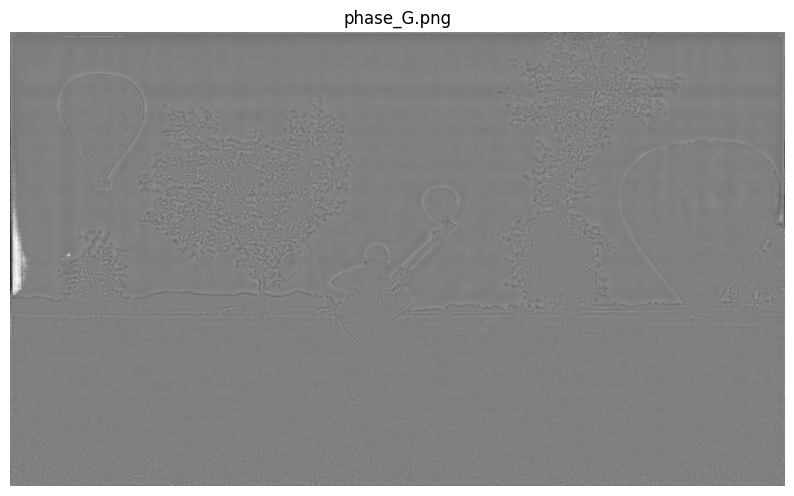

In [ ]:
# @title Simple Mode
clear_outputs = True #
# mode = "Simple" #@param ["Simple"] {type:"string"}
prompt = "A guitarist playing near a hot-air balloon at sunset." #@param {type:"string"}
inference_steps = 40
output_directory = "CGH_output/"
display_generated_image = True
display_depth_planes = False
display_phase_only_hologram = True
display_colored_reconstruction = False
device_set = 'cuda'

import importlib

package_name = 'text2hologram'
package_spec = importlib.util.find_spec(package_name)
# ---- Package Installation ----
if package_spec is None:
    !pip install text2hologram

# ---- Imports ----
from IPython.display import clear_output
import sys
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch

# Text2Hologram specific imports
from text2hologram.__main__ import parse_arguments
from text2hologram.settings import load_settings, update_settings
from text2hologram.device_setup import setup_device
from text2hologram.model import load_model
from text2hologram.image_generation import generate_images
from text2hologram.post_processing import process_depth_map, cgh
from text2hologram.super_resolution import super_resolve_image
from text2hologram.utils import display_images_from_directory, create_dirs, combine_rgb_images, display_images_from_directory, generate_image_names, display_selected_images
from text2hologram.color_recon import colored_recon

# ---- Setup and Model Loading ----
settings = {
    "general": {
        "device": device_set,
  }
}
# Set up the device
device = setup_device(settings)

# Load the model and necessary transforms
midas, pipe, transform = load_model(device)

# ---- Finalize Setup ----
if clear_outputs:
  clear_output()
print("Setup complete! You're now ready to create and display images.")

settings = {

    "general": {
        "device": device_set,
        "iterations": 200,
        "propagation type": "Bandlimited Angular Spectrum",
        "output directory": output_directory,
        "learning rate": 0.04,
        "hologram number": 1
    },
    "diffusion": {
        "inference_steps": 40,
        "resolution": [544, 960],
        "super_reso":'true'
    },
    "target": {
        "depth filename": "depthmap.jpg",
        "scheme": "defocus",
        "color channel": 1,
        "defocus blur size": 20,
        "blur ratio": 3,
        "number of planes": 5,
        "mask limits": [0.0, 1.0, 0.0, 1.0],
        "multiplier": 1.0,
        "weights": [1.0, 1.0, 1.0, 0.0]
    },
    "image": {
        "location": 0.0,
        "delta": 0.001,
        "zero mode distance": 0.15
    },
    "slm": {
        "model": "Jasper Display Educational 4k",
        "pixel pitch": 0.00000374,
        "resolution": [2400,4094]
    },
    "beam": {
        "wavelength": 0.000000518
    }
}


# Generate images
image_path, images = generate_images(pipe, prompt, settings, device)
torch.cuda.empty_cache()
if settings['diffusion']['super_reso']:
    print("Super-resolution is applied to create 4K images, requiring more memory. If crashing, use --super_reso=false to disable.")
    image_sr = super_resolve_image(image_path)
    settings['slm']['resolution'] = [2400,4094]

else:

    print("Super-resolution is off. Use --super_reso=true for 4K images. For memory issues, try on Colab:https://github.com/Linsonng/text2hologram/tree/main")
    image_sr = images[0]
    settings['slm']['resolution'] =  settings['diffusion']['resolution']
torch.cuda.empty_cache()

# Process the depth map
process_depth_map(midas, transform, np.array(image_sr), device, settings)

torch.cuda.empty_cache()

# Perform CGH
cgh(settings, image_path) # G
if os.path.exists(output_directory+'phase_0000.png'):
  os.rename(output_directory+'phase_0000.png', output_directory+'phase_G.png')

if display_colored_reconstruction:

  settings['target']['color channel'] = 0 # channel R
  settings['beam']['wavelength'] = 0.000000639 # wavelength of red light
  torch.cuda.empty_cache()
  cgh(settings, image_path)
  if os.path.exists(output_directory+'phase_0000.png'):
    os.rename(output_directory+'phase_0000.png', output_directory+'phase_R.png')


  settings['target']['color channel'] = 2 # channel B
  settings['beam']['wavelength'] = 0.000000473 # wavelength of blue light
  torch.cuda.empty_cache()
  cgh(settings, image_path)
  if os.path.exists(output_directory+'phase_0000.png'):
    os.rename(output_directory+'phase_0000.png', output_directory+'phase_B.png')

  torch.cuda.empty_cache()
  combine_rgb_images(output_directory+'phase_R.png', output_directory+'phase_G.png', output_directory+'phase_B.png', output_path=output_directory+'combined_rgb.png')
  colored_recon(output_directory,'combined_rgb.png',settings['target']["number of planes"])

image_name = prompt[0:20]


if display_generated_image:
  display_images_from_directory(output_directory, image_names=image_name+'.jpg', title=None, ext='.jpg', size=(10, 10))

if display_depth_planes:
  display_images_from_directory(output_directory, image_names='depth.png', title=None, ext='.png', size=(10, 10))

if display_phase_only_hologram:
  display_images_from_directory(output_directory, image_names='phase_G.png', title=None, ext='.png', size=(10, 10))



<a name="custom-mode"></a>
## Custom Mode

### Introduction

This is the Custom Mode of the Text2Hologram pipeline! This mode is designed for users who have some familiarity with holography and would like more control over the hologram generation process. Unlike Simple Mode, Custom Mode allows you to tweak several key parameters while still providing reasonable default settings for a smooth experience.

### How to Use

1. **Provide Parameters**: Input your text prompt along with any specific settings you'd like to change, such as the number of inference steps or the output directory.
2. **Run the Cell**: Execute the cell to start the hologram generation process.
3. **View Results**: After the process is complete, the generated hologram and any additional outputs will be displayed below.

### What to Expect

- **Intermediate Control**: This mode provides a balance between ease-of-use and configurability.
- **Guided Experience**: Each setting comes with a brief explanation to guide your choices.
- **Quality Output**: Control key parameters to customize the quality and appearance of your hologram.

### Available Customizations & Parameters Guide

#### General Settings
  
- **`prompt`**: Input the text description for the scene you'd like to convert into a hologram.

#### Generative Model

- **`inference_steps`**: Sets the number of inference steps for the generative model. Higher numbers may produce more detailed images but will take longer.
  
- **`output_directory`**: Specifies the directory where the generated hologram will be saved.

#### Computer-Generated Holography (CGH)

- **`number_of_planes`**: Sets the number of depth planes for the hologram. Increasing this number will split the image into more depth layers, but requires more computing resources.

- **`cgh_iterations`**: Sets the number of iterations for the CGH model. More iterations may improve the quality of the hologram but will take longer.

#### Display Options

- **`display_generated_image`**: If `True`, the generated image will be displayed after the process.

- **`display_depth_planes`**: If `True`, the depth planes of the hologram will be displayed.

- **`display_phase_only_hologram`**: If `True`, the phase-only hologram will be displayed.

- **`display_colored_reconstruction`**: If "True", a reconstruction of the full channel will be applied and a colored reconstruction of the hologram will be displayed.

### Important Notes

1. **GPU**: Some options are very computationally intensive. With all options turned on, the A100 GPU is recommended. The A100 is one of the most advanced GPUs available for machine learning and high-performance computing, with large memory capacity. Using high-end GPUs such as the A100 may require a Colab Pro subscription, and even then, availability is not guaranteed. To set the hardware accelerator in Colab: 1. Click on the **Runtime** menu; 2. Select **Change runtime type**; 3. Choose your preferred hardware accelerator from the dropdown menu.
2. **Processing Time**: The time taken for the generation process will depend on the complexity of your settings. More iterations, planes, and higher resolution will increase the processing time. At default settings, it typically takes 2 minutes on the A100.

Feel free to adjust the parameters and generate your customized hologram!

Setup complete! You're now ready to create and display images.
Creating images.


  0%|          | 0/40 [00:00<?, ?it/s]

Image saved as CGH_output//A cyberpunk waterfal.jpg
Super-resolution is applied to create 4K images, requiring more memory. If crashing, use --super_reso=false to disable.
single-image-super-resolution-1032 already downloaded to model
Depth acquired.


Gradient Descent, loss:12919.9365
Outputs stored at CGH_output/


Gradient Descent, loss:18199.9180
Outputs stored at CGH_output/


Gradient Descent, loss:15708.5762
Outputs stored at CGH_output/


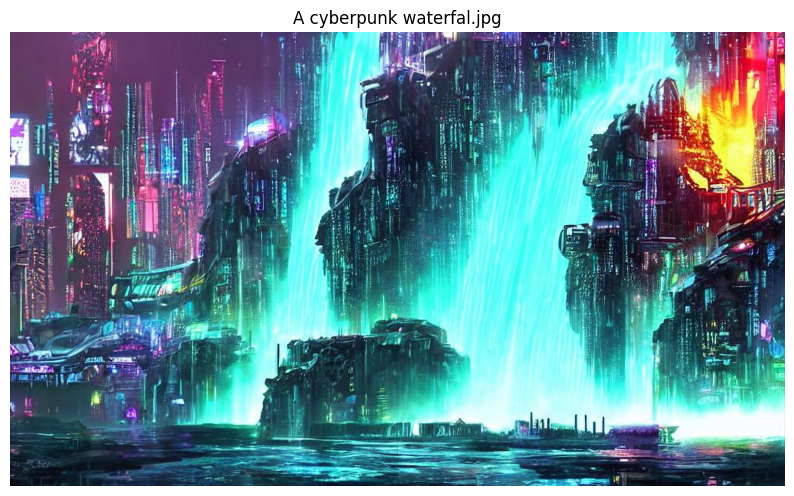

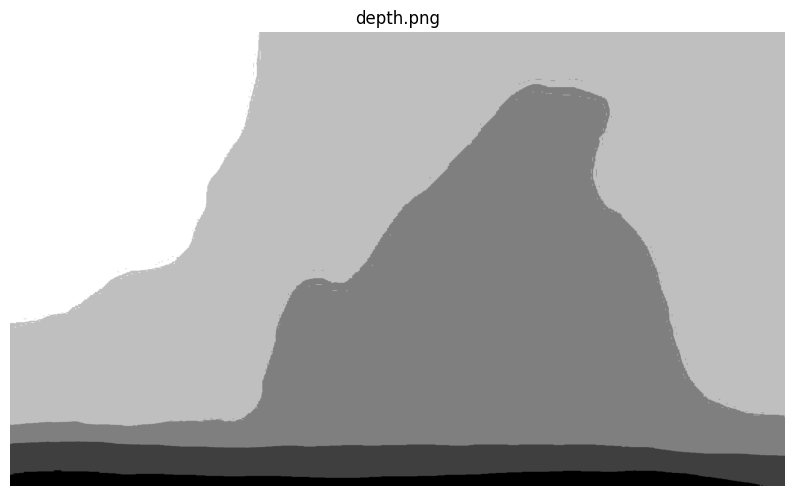

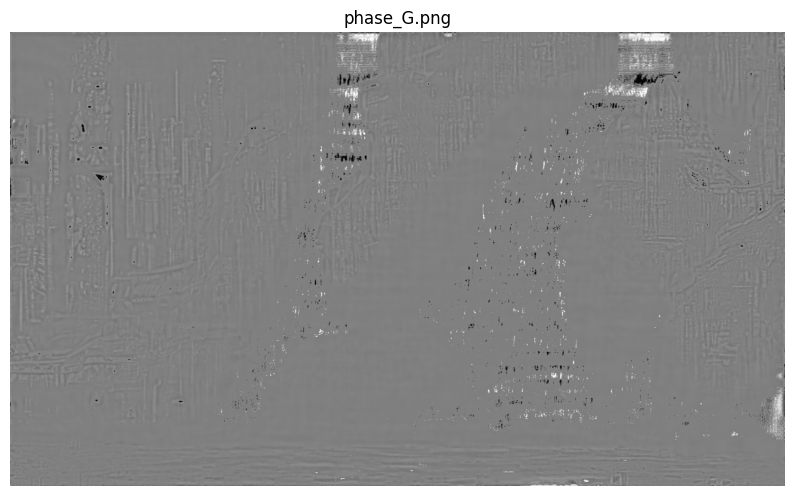

In [ ]:
# @title Custom Mode
clear_outputs = True
# mode = "Simple" #@param ["Simple"] {type:"string"}
prompt = "A cyberpunk waterfall" #@param {type:"string"}

# @markdown For generative model:
inference_steps = 40 # @param {type:"number"}
output_directory = "CGH_output/" #@param {type:"string"}
# @markdown For computer generated holography:
number_of_planes = 5 # @param {type:"number"}
cgh_iterations = 200 # @param {type:"number"}
cgh_lr = 0.04 #
cgh_channel = 1 #
cgh_wavelength_1 = 0.000000518
cgh_wavelength_0 = 0.000000473
cgh_wavelength_2 = 0.000000639
# @markdown Display options:
display_generated_image = True #@param {type:"boolean"}
display_depth_planes = True # @param {type:"boolean"}
display_phase_only_hologram = True # @param {type:"boolean"}
display_colored_reconstruction = True # @param {type:"boolean"}
device_set = 'cuda'

import importlib

package_name = 'text2hologram'
package_spec = importlib.util.find_spec(package_name)
# ---- Package Installation ----
if package_spec is None:
    !pip install text2hologram

# ---- Imports ----
from IPython.display import clear_output
import sys
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch

# Text2Hologram specific imports
from text2hologram.__main__ import parse_arguments
from text2hologram.settings import load_settings, update_settings
from text2hologram.device_setup import setup_device
from text2hologram.model import load_model
from text2hologram.image_generation import generate_images
from text2hologram.post_processing import process_depth_map, cgh
from text2hologram.super_resolution import super_resolve_image
from text2hologram.utils import display_images_from_directory, create_dirs, combine_rgb_images, display_images_from_directory, generate_image_names, display_selected_images
from text2hologram.color_recon import colored_recon

# ---- Setup and Model Loading ----
settings = {
    "general": {
        "device": device_set,
  }
}
# Set up the device
device = setup_device(settings)

# Load the model and necessary transforms
midas, pipe, transform = load_model(device)

# ---- Finalize Setup ----
if clear_outputs:
  clear_output()
print("Setup complete! You're now ready to create and display images.")

settings = {

    "general": {
        "device": device_set,
        "iterations": cgh_iterations,
        "propagation type": "Bandlimited Angular Spectrum",
        "output directory": output_directory,
        "learning rate": cgh_lr,
        "hologram number": 1
    },
    "diffusion": {
        "inference_steps": 40,
        "resolution": [544, 960],
        "super_reso":'true'
    },
    "target": {
        "depth filename": "depthmap.jpg",
        "scheme": "defocus",
        "color channel": cgh_channel,
        "defocus blur size": 20,
        "blur ratio": 3,
        "number of planes": number_of_planes,
        "mask limits": [0.0, 1.0, 0.0, 1.0],
        "multiplier": 1.0,
        "weights": [1.0, 1.0, 1.0, 0.0]
    },
    "image": {
        "location": 0.0,
        "delta": 0.001,
        "zero mode distance": 0.15
    },
    "slm": {
        "model": "Jasper Display Educational 4k",
        "pixel pitch": 0.00000374,
        "resolution": [2400,4094]
    },
    "beam": {
        "wavelength": cgh_wavelength_1
    }
}


# Generate images
image_path, images = generate_images(pipe, prompt, settings, device)
torch.cuda.empty_cache()
if settings['diffusion']['super_reso']:
    print("Super-resolution is applied to create 4K images, requiring more memory. If crashing, use --super_reso=false to disable.")
    image_sr = super_resolve_image(image_path)
    settings['slm']['resolution'] = [2400,4094]

else:

    print("Super-resolution is off. Use --super_reso=true for 4K images. For memory issues, try on Colab:https://github.com/Linsonng/text2hologram/tree/main")
    image_sr = images[0]
    settings['slm']['resolution'] =  settings['diffusion']['resolution']
torch.cuda.empty_cache()

# Process the depth map
process_depth_map(midas, transform, np.array(image_sr), device, settings)

torch.cuda.empty_cache()

# Perform CGH
cgh(settings, image_path) # G
if os.path.exists(output_directory+'phase_0000.png'):
  os.rename(output_directory+'phase_0000.png', output_directory+'phase_G.png')

if display_colored_reconstruction:

  settings['target']['color channel'] = 0 # channel R
  settings['beam']['wavelength'] = cgh_wavelength_0 # 0.000000639 # wavelength of red light
  torch.cuda.empty_cache()
  cgh(settings, image_path)
  if os.path.exists(output_directory+'phase_0000.png'):
    os.rename(output_directory+'phase_0000.png', output_directory+'phase_R.png')


  settings['target']['color channel'] = 2 # channel B
  settings['beam']['wavelength'] = cgh_wavelength_2 # 0.000000473 # wavelength of blue light
  torch.cuda.empty_cache()
  cgh(settings, image_path)
  if os.path.exists(output_directory+'phase_0000.png'):
    os.rename(output_directory+'phase_0000.png', output_directory+'phase_B.png')

  torch.cuda.empty_cache()
  combine_rgb_images(output_directory+'phase_R.png', output_directory+'phase_G.png', output_directory+'phase_B.png', output_path=output_directory+'combined_rgb.png')
  colored_recon(output_directory,'combined_rgb.png',settings['target']["number of planes"])

image_name = prompt[0:20]


if display_generated_image:
  display_images_from_directory(output_directory, image_names=image_name+'.jpg', title=None, ext='.jpg', size=(10, 10))

if display_depth_planes:
  display_images_from_directory(output_directory, image_names='depth.png', title=None, ext='.png', size=(10, 10))

if display_phase_only_hologram:
  display_images_from_directory(output_directory, image_names='phase_G.png', title=None, ext='.png', size=(10, 10))



<a name="researcher-mode"></a>
## Researcher Mode

### **Introduction**

Welcome to the Researcher Mode of the Text2Hologram pipeline. This mode is designed for academics, researchers, and experts who need full control over every aspect of the hologram generation process. Here, you'll find all parameters exposed for fine-tuning, along with advanced settings not available in other modes.

### **How to Use**

1. **Adjust the Parameters**: Feel free to modify any setting, even change the weights of the model.
2. **Run the Cell**: Modify and execute every cell to initiate the hologram generation pipeline step by step.

### **Important Notes**

1. **Expertise Required**: This mode is for users who have a good understanding of the subject matter and can responsibly modify advanced settings.
2. **Resource Intensive**: Given the advanced nature of this mode, certain settings may be highly computational and require powerful hardware.
3. **GPU**: Some options are very computationally intensive. With all options turned on, the A100 GPU is recommended. The A100 is one of the most advanced GPUs available for machine learning and high-performance computing, with large memory capacity. Using high-end GPUs such as the A100 may require a Colab Pro subscription, and even then, availability is not guaranteed. To set the hardware accelerator in Colab: 1. Click on the **Runtime** menu; 2. Select **Change runtime type**; 3. Choose your preferred hardware accelerator from the dropdown menu.
4. **Processing Time**: The time taken for the generation process will depend on the complexity of your settings. More iterations, planes, and higher resolution will increase the processing time. At default settings, it typically takes 2 minutes on the A100.


### **Parameters Guide**

#### General Settings
  
- **`prompt`**: Input the text description for the scene you'd like to convert into a hologram.

#### Generative Model

- **`inference_steps`**: Sets the number of inference steps for the generative model. Higher numbers may produce more detailed images but will take longer.
  
- **`output_directory`**: Specifies the directory where the generated hologram will be saved.

- **'model_id'**: Select the weight of your model. For example, here is a [library](https://huggingface.co/models?library=diffusers) for generative models.

#### Computer-Generated Holography (CGH)

- **`number_of_planes`**: Sets the number of depth planes for the hologram. Increasing this number will split the image into more depth layers, but requires more computing resources.

- **`cgh_iterations`**: Sets the number of iterations for the CGH model. More iterations may improve the quality of the hologram but will take longer.

- **`cgh_lr`**: Sets the learning rate for the CGH model. A higher learning rate speeds up the model but may compromise quality.

- **`cgh_channel`**: Sets the color channel for the CGH model. The options are 0 for Red, 1 for Green, and 2 for Blue.

- **`cgh_wavelength`**: Sets the wavelength for the corresponding color channels. These values are preset for RGB channels.

#### Display Options

- **`display_generated_image`**: If `True`, the generated image will be displayed after the process.

- **`display_depth_planes`**: If `True`, the depth planes of the hologram will be displayed.

- **`display_phase_only_hologram`**: If `True`, the phase-only hologram will be displayed.

- **`display_colored_reconstruction`**: If "True", a reconstruction of the full channel will be applied and a colored reconstruction of the hologram will be displayed.

### Contact

Pengze Li is responsible for this notebook, who is at [linsonng@163.com](mailto:linsonng@163.com).

In [ ]:
# @title Researcher Mode - parameters
clear_outputs = True #
# mode = "Simple" #@param ["Simple"] {type:"string"}
prompt = "A ferrari car running on snowy mountain." #@param {type:"string"}

# @markdown For generative model:
inference_steps = 40 # @param {type:"number"}
output_directory = "CGH_output/" #@param {type:"string"}
model_id = "runwayml/stable-diffusion-v1-5" # @param

# @markdown For computer generated holography:
number_of_planes = 5 # @param {type:"number"}
cgh_iterations = 200 # @param {type:"number"}
cgh_lr = 0.04 # @param {type:"number"}
cgh_channel = 1 # @param ["0", "1", "2"] {type:"raw"}
cgh_wavelegnth_1 = 0.000000518# @param {type:"number"}
cgh_wavelegnth_0 = 0.000000639# @param {type:"number"}
cgh_wavelegnth_2 = 0.000000473# @param {type:"number"}

# @markdown Display options:
display_generated_image = True #@param {type:"boolean"}
display_depth_planes = True # @param {type:"boolean"}
display_phase_only_hologram = True # @param {type:"boolean"}
display_colored_reconstruction = True # @param {type:"boolean"}
device_set = 'cuda'

In [ ]:
# @title Researcher Mode - Setups

import importlib

package_name = 'text2hologram'
package_spec = importlib.util.find_spec(package_name)
# ---- Package Installation ----
if package_spec is None:
    !pip install text2hologram

# ---- Imports ----
from IPython.display import clear_output
import sys
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch

# Text2Hologram specific imports
from text2hologram.__main__ import parse_arguments
from text2hologram.settings import load_settings, update_settings
from text2hologram.device_setup import setup_device
from text2hologram.model import load_model
from text2hologram.image_generation import generate_images
from text2hologram.post_processing import process_depth_map, cgh
from text2hologram.super_resolution import super_resolve_image
from text2hologram.utils import display_images_from_directory, create_dirs, combine_rgb_images, display_images_from_directory, generate_image_names, display_selected_images
from text2hologram.color_recon import colored_recon

# ---- Setup and Model Loading ----
settings = {
    "general": {
        "device": device_set,
  }
}
# Set up the device
device = setup_device(settings)

# Load the model and necessary transforms
midas, pipe, transform = load_model(device,model_id)

# ---- Finalize Setup ----
if clear_outputs:
  clear_output()
print("Setup complete! You're now ready to create and display images.")

settings = {

    "general": {
        "device": device_set,
        "iterations": cgh_iterations,
        "propagation type": "Bandlimited Angular Spectrum",
        "output directory": output_directory,
        "learning rate": cgh_lr,
        "hologram number": 1
    },
    "diffusion": {
        "inference_steps": 40,
        "resolution": [544, 960],
        "super_reso":'true'
    },
    "target": {
        "depth filename": "depthmap.jpg",
        "scheme": "defocus",
        "color channel": cgh_channel,
        "defocus blur size": 20,
        "blur ratio": 3,
        "number of planes": number_of_planes,
        "mask limits": [0.0, 1.0, 0.0, 1.0],
        "multiplier": 1.0,
        "weights": [1.0, 1.0, 1.0, 0.0]
    },
    "image": {
        "location": 0.0,
        "delta": 0.001,
        "zero mode distance": 0.15
    },
    "slm": {
        "model": "Jasper Display Educational 4k",
        "pixel pitch": 0.00000374,
        "resolution": [2400,4094]
    },
    "beam": {
        "wavelength": cgh_wavelength_1
    }
}

Setup complete! You're now ready to create and display images.


In [ ]:
# @title Researcher Mode - Pipeline - image generation

# Generate images
image_path, images = generate_images(pipe, prompt, settings, device)



Creating images.


  0%|          | 0/40 [00:00<?, ?it/s]

Image saved as CGH_output//A ferrari car runnin.jpg


In [ ]:
# @title Researcher Mode - Pipeline - super-resolution
import time
start_time = time.time()


# super-resolution
torch.cuda.empty_cache()
if settings['diffusion']['super_reso']:
    print("Super-resolution is applied to create 4K images, requiring more memory. If crashing, use --super_reso=false to disable.")
    image_sr = super_resolve_image(image_path)
    settings['slm']['resolution'] = [2400,4094]

else:

    print("Super-resolution is off. Use --super_reso=true for 4K images. For memory issues, try on Colab:https://github.com/Linsonng/text2hologram/tree/main")
    image_sr = images[0]
    settings['slm']['resolution'] =  settings['diffusion']['resolution']
torch.cuda.empty_cache()

end_time = time.time()

elapsed_time = end_time - start_time
print("Processing time: " + str(elapsed_time))

Super-resolution is applied to create 4K images, requiring more memory. If crashing, use --super_reso=false to disable.
single-image-super-resolution-1032 already downloaded to model
Processing time: 0.9523410797119141


In [ ]:
# @title Researcher Mode - Pipeline - depth estimation
import time
start_time = time.time()
# Process the depth map
process_depth_map(midas, transform, np.array(image_sr), device, settings)

torch.cuda.empty_cache()

end_time = time.time()
elapsed_time = end_time - start_time
print("Processing time: " + str(elapsed_time))

Depth acquired.
Processing time: 0.26653385162353516


In [ ]:
# @title Researcher Mode - Pipeline - computer generated holography
import time
start_time = time.time()

# Perform CGH
cgh(settings, image_path) # G
if os.path.exists(output_directory+'phase_0000.png'):
  os.rename(output_directory+'phase_0000.png', output_directory+'phase_G.png')

if display_colored_reconstruction:

  settings['target']['color channel'] = 0 # channel R
  settings['beam']['wavelength'] = cgh_wavelength_0 # 0.000000639 # wavelength of red light
  torch.cuda.empty_cache()
  cgh(settings, image_path)
  if os.path.exists(output_directory+'phase_0000.png'):
    os.rename(output_directory+'phase_0000.png', output_directory+'phase_R.png')


  settings['target']['color channel'] = 2 # channel B
  settings['beam']['wavelength'] = cgh_wavelength_2 # 0.000000473 # wavelength of blue light
  torch.cuda.empty_cache()
  cgh(settings, image_path)
  if os.path.exists(output_directory+'phase_0000.png'):
    os.rename(output_directory+'phase_0000.png', output_directory+'phase_B.png')



Gradient Descent, loss:14185.4375
Outputs stored at CGH_output/


Gradient Descent, loss:16163.1855
Outputs stored at CGH_output/


Gradient Descent, loss:20455.0137
Outputs stored at CGH_output/


In [ ]:
# @title Researcher Mode - Pipeline - reconstruction
if display_colored_reconstruction:
  torch.cuda.empty_cache()
  combine_rgb_images(output_directory+'phase_R.png', output_directory+'phase_G.png', output_directory+'phase_B.png', output_path=output_directory+'combined_rgb.png')
  colored_recon(output_directory,'combined_rgb.png',settings['target']["number of planes"])


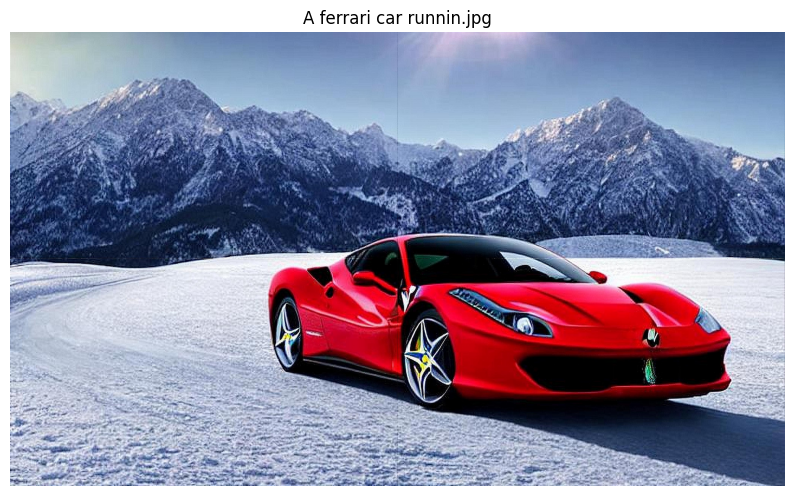

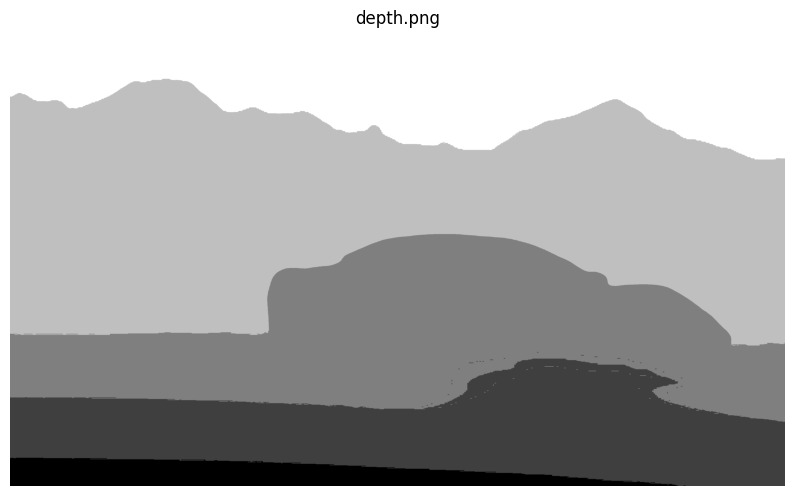

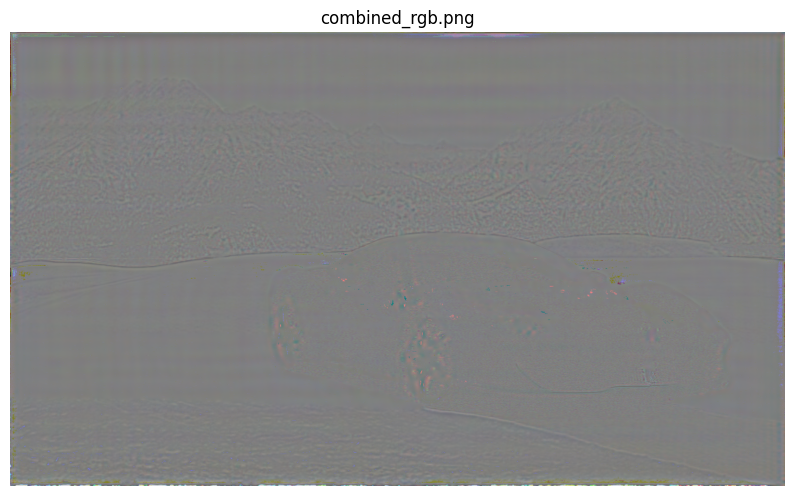

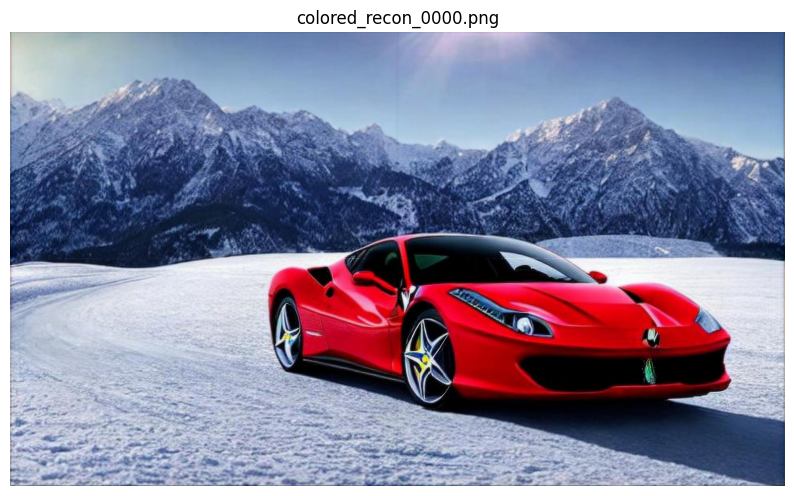

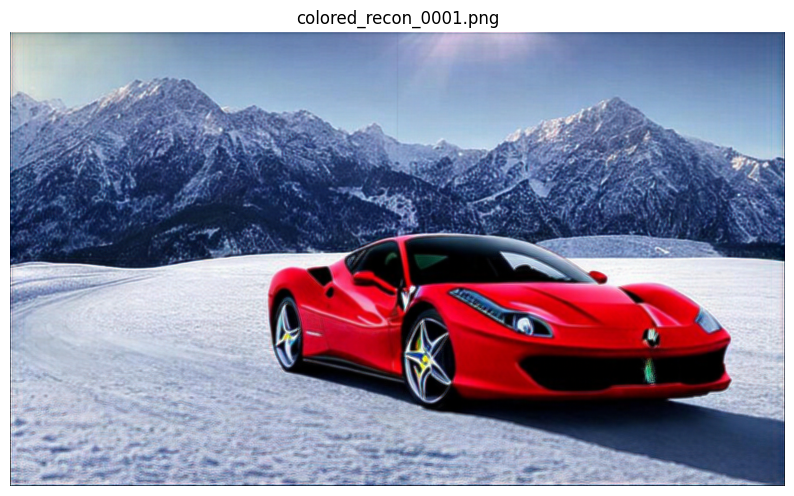

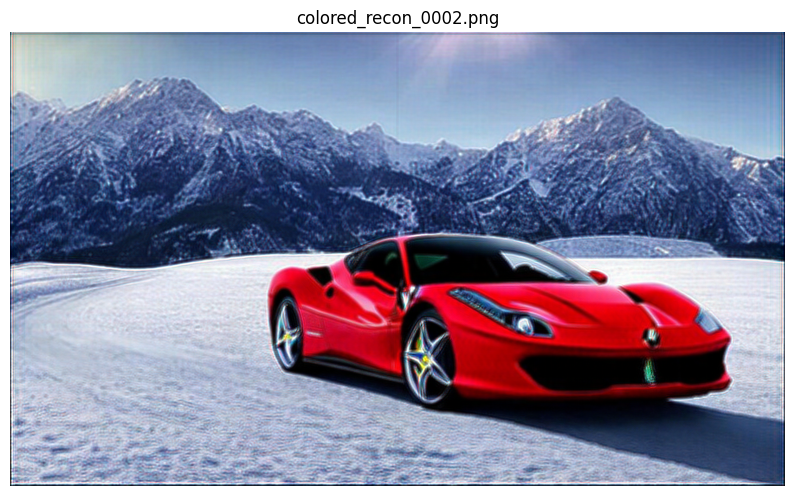

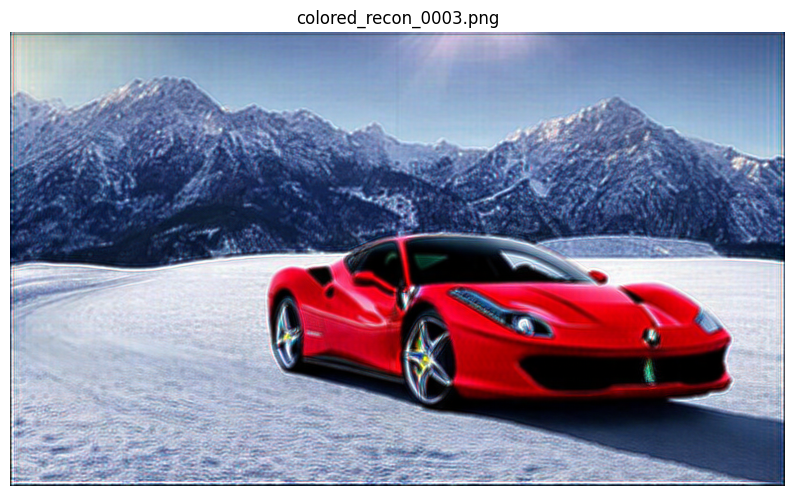

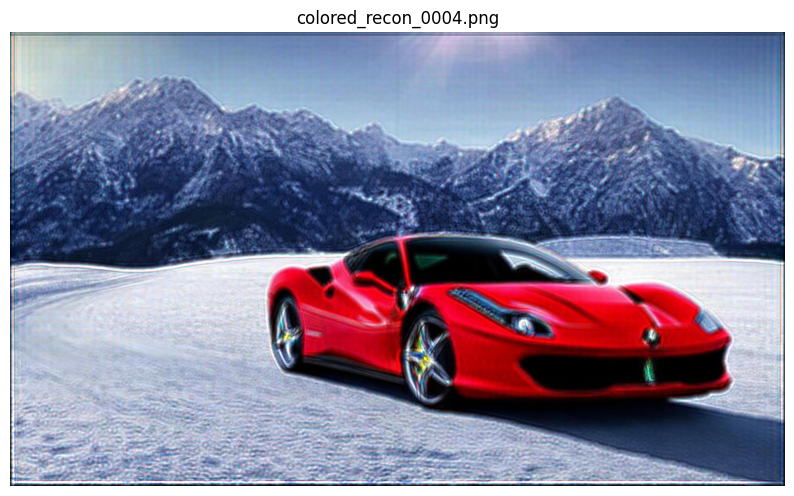

In [ ]:
# @title Researcher Mode - Pipeline - display


image_name = prompt[0:20]


if display_generated_image:
  display_images_from_directory(output_directory, image_names=image_name+'.jpg', title=None, ext='.jpg', size=(10, 10))

if display_depth_planes:
  display_images_from_directory(output_directory, image_names='depth.png', title=None, ext='.png', size=(10, 10))

if display_phase_only_hologram:
  display_images_from_directory(output_directory, image_names='combined_rgb.png', title=None, ext='.png', size=(10, 10))

if display_colored_reconstruction:
  image_names = generate_image_names("colored_recon", settings['target']["number of planes"])
  display_images_from_directory(output_directory, image_names=image_names, title=None, ext='.png', size=(10, 10))

# Q&A Section

## Q1: I encountered a CUDA out-of-memory error. How can I fix it?
**Answer**: Encountering a CUDA out-of-memory error is not uncommon, especially when dealing with 4K images and deep learning algorithms. There are several approaches to tackle this issue:

1. **Empty Cache**: You can try executing `torch.cuda.empty_cache()` to clear the GPU cache and then restart the computation from the last successful checkpoint.
2. **Modular Execution**: Given that the code is highly modular, you can save intermediate results and start a new session, resuming from where the last session stopped.
3. **Upgrad Hardware**: A more straightforward but potentially costly solution is to switch to GPUs with higher memory capacity, such as the A100 GPU available on Colab.

## Q2: The process seems to be taking a long time. What's happening?
**Answer**: The initial setup, defined in `setup.py`, installs and configures the necessary libraries. Once you've entered your custom text prompt and initiated the run, most of the time is spent on image generation and hologram optimization. If you opt for color multi-plane reconstruction, the process will likely take more than double the time, approximately 2 minutes on an A100 GPU.

## Q3: Why am I seeing a 'noise' image?
**Answer**: What you're seeing is the phase of the hologram. In holography, the phase information encodes the depth of the 3D structure of the object being imaged. The pattern that appears like random noise or spots to the human eye is actually crucial for reconstructing the 3D image. Below the phase map, you'll find reconstructed images at various depths generated from that same phase information.

## Q4: Can I run this notebook on my own computer?
**Answer**: Absolutely. The source code is publicly available on PyPI, allowing you to run this notebook on any device with an internet connection. However, be cautious as some functions are computationally intensive and may require robust hardware.

## Q5: How many steps should I run for the diffusion model?
**Answer**: The number of steps for a text-to-image diffusion model is a trade-off between image quality and computational time. Generally, more steps lead to higher-quality images, but the improvement tends to plateau after a certain point. The computational time typically increases linearly with the number of steps. Based on experience, more than 30 inference steps usually yield stable and satisfactory results.

## Q6: What if I encounter an error not covered above?
**Answer**: For errors or issues not addressed in this FAQ, you can contact Pengze Li, who is responsible for this notebook. You can reach him at [linsonng@163.com](mailto:linsonng@163.com).
